# Import

In [1]:
# importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [2]:
# Importing the dataset
%time train = pd.read_csv('bank.csv',sep=';')

Wall time: 64 ms


# Preprocessing

In [3]:
df = train.copy()

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [6]:
df.describe(exclude=np.number)

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,yes,no,cellular,may,unknown,no
freq,969,2797,2306,4445,2559,3830,2896,1398,3705,4000


In [7]:
df.dtypes.value_counts()

object    10
int64      7
dtype: int64

## Destribution of Dependent Variable

no     4000
yes     521
Name: y, dtype: int64


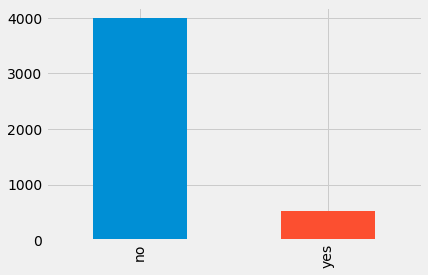

In [8]:
plt.style.use('fivethirtyeight')
print(df.y.value_counts())
df.y.value_counts().plot.bar()

## Missing Values

In [9]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

## Label Encoding

In [10]:
colname = []
for x in df.columns:
    if df[x].dtype == 'object':
        colname.append(x)
colname

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

In [11]:
from sklearn import preprocessing
le = {}
for x in colname:
    le[x] = preprocessing.LabelEncoder()
for x in colname:
    df[x] = le[x].fit_transform(df[x])

## Correlation

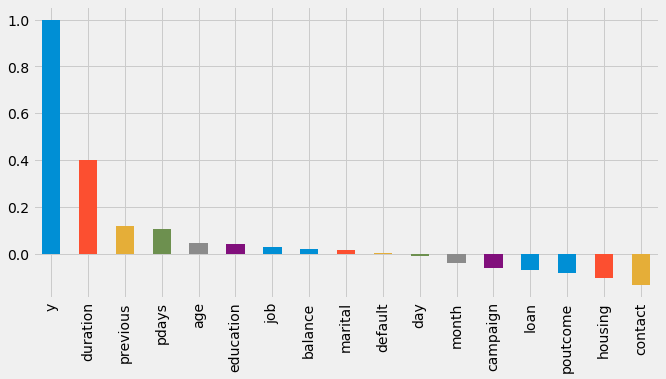

In [12]:
df.corr()['y'].sort_values(ascending=False).plot.bar(figsize=(10,5))

## Dependent and Independent Variable

In [13]:
X = df.copy()
y = X.pop('y')

## Training and Test set

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=.3)

## Building the model

In [15]:
# Fitting the model
from sklearn.ensemble import RandomForestClassifier
m = RandomForestClassifier(n_jobs=-1,oob_score=True,n_estimators=100)
m.fit(X_train,y_train),m.oob_score_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
             oob_score=True, random_state=None, verbose=0, warm_start=False),
 0.8906447534766119)

In [16]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
y_pred = m.predict(X_valid)
cm = confusion_matrix(y_valid,y_pred)
print(cm)
print(classification_report(y_valid,y_pred))
print(accuracy_score(y_valid,y_pred))
print(roc_auc_score(y_valid,y_pred))

[[1182   31]
 [  99   45]]
             precision    recall  f1-score   support

          0       0.92      0.97      0.95      1213
          1       0.59      0.31      0.41       144

avg / total       0.89      0.90      0.89      1357

0.9042004421518055
0.6434717642209398


# Tuning the model

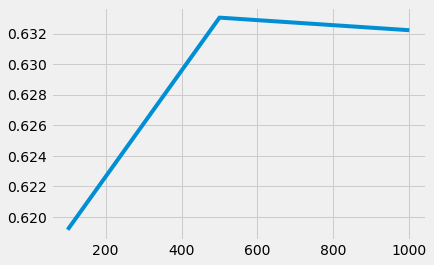

In [19]:
results = []
ntree = [100,500,1000]
for tree in ntree:
    m = RandomForestClassifier(n_jobs=-1,n_estimators=tree,oob_score=True,random_state=42)
    m.fit(X_train,y_train)
    y_pred = m.predict(X_valid)
    res = roc_auc_score(y_valid,y_pred)
    results.append(res)

pd.Series(results,ntree).plot()

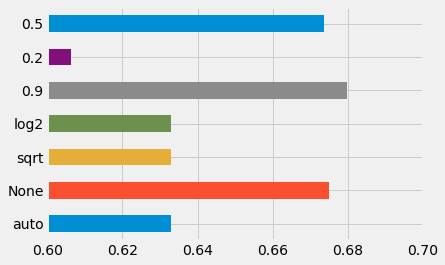

In [20]:
results = []
max_feature_options = ['auto',None,'sqrt','log2',.9,.2,.5]
for max_features in max_feature_options:
    m = RandomForestClassifier(n_jobs=-1,n_estimators=500,oob_score=True,random_state=42,max_features=max_features)
    m.fit(X_train,y_train)
    y_pred = m.predict(X_valid)
    res = roc_auc_score(y_valid,y_pred)
    results.append(res)

pd.Series(results,max_feature_options).plot(kind='barh',xlim=(.6,.7))

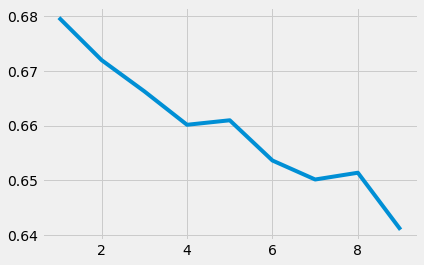

In [21]:
%timeit
results = []
min_samples = [1,2,3,4,5,6,7,8,9]
for min_sample in min_samples:
    m = RandomForestClassifier(n_jobs=-1,n_estimators=500,oob_score=True,random_state=42,
                               min_samples_leaf=min_sample,max_features=.9)
    m.fit(X_train,y_train)
    y_pred = m.predict(X_valid)
    res = roc_auc_score(y_valid,y_pred)
    results.append(res)

pd.Series(results,min_samples).plot()

In [22]:
m = RandomForestClassifier(n_jobs=-1,n_estimators=500,oob_score=True,random_state=42,max_features=.9)
m.fit(X_train,y_train)
m.score(X_train,y_train)

1.0

In [24]:
y_pred = m.predict(X_valid)
cm = confusion_matrix(y_valid,y_pred)
print(cm)
print(classification_report(y_valid,y_pred))
print(accuracy_score(y_valid,y_pred))
print(roc_auc_score(y_valid,y_pred))

[[1169   44]
 [  87   57]]
             precision    recall  f1-score   support

          0       0.93      0.96      0.95      1213
          1       0.56      0.40      0.47       144

avg / total       0.89      0.90      0.90      1357

0.9034635224760501
0.6797798158834845


# Feature Engineering

In [25]:
def rf_feat_importance(m,df):
    return pd.DataFrame({'cols':df.columns,
                       'imp':m.feature_importances_}).sort_values(by='imp',ascending=False)

In [26]:
fi = rf_feat_importance(m, X_train);fi[:10]

,cols,imp
11,duration,0.293313
5,balance,0.113355
0,age,0.107707
9,day,0.101213
10,month,0.088804
13,pdays,0.059465
1,job,0.044441
15,poutcome,0.037123
12,campaign,0.031693
3,education,0.025933


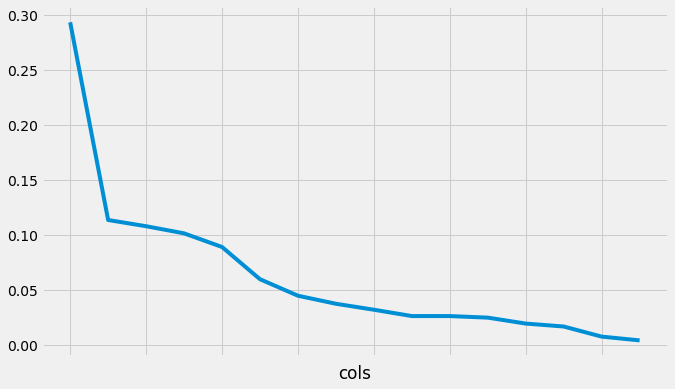

In [27]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False)

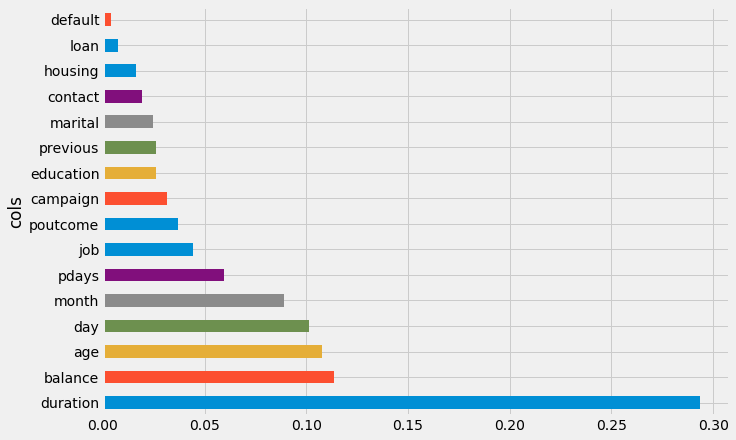

In [28]:
def plot_fi(fi): 
  return fi.plot('cols','imp','barh', figsize=(10,7), legend=False)
plot_fi(fi[:30]);

### Duration

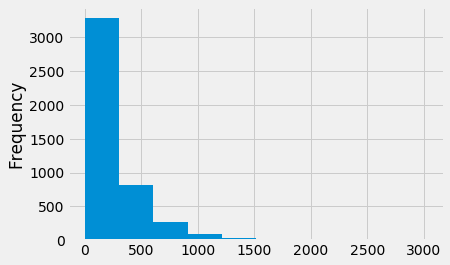

In [29]:
# Destribution of Duration
df.duration.plot.hist()

C:\Users\SONU KUMAR JHA\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Count')

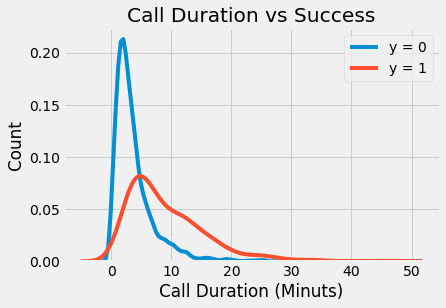

In [30]:
# Call Duration vs Success
plt.style.use('fivethirtyeight')
sns.kdeplot(df.loc[df['y']==0,'duration']/60,label='y = 0')
sns.kdeplot(df.loc[df['y']==1,'duration']/60,label='y = 1')
plt.title('Call Duration vs Success')
plt.xlabel('Call Duration (Minuts)')
plt.ylabel('Count')

## Balance

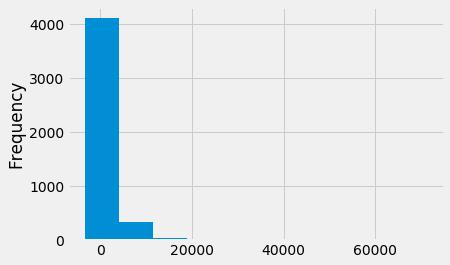

In [31]:
df.balance.plot.hist()

C:\Users\SONU KUMAR JHA\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Count')

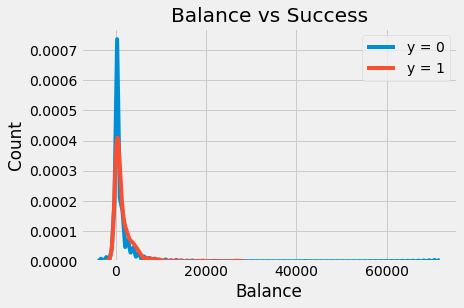

In [32]:
# Balance vs Success
sns.kdeplot(df.loc[df['y']==0,'balance'],label='y = 0')
sns.kdeplot(df.loc[df['y']==1,'balance'],label='y = 1')
plt.title('Balance vs Success')
plt.xlabel('Balance')
plt.ylabel('Count')

## Age

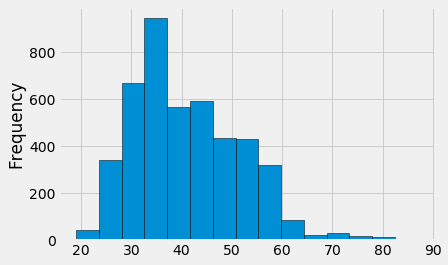

In [33]:
df.age.plot.hist(bins=15,edgecolor = 'k')

In [34]:
age_data = df[['y','age']]
age_data['age_binned'] = pd.cut(age_data['age'],bins=np.linspace(20,90,8))
age_data.head()

C:\Users\SONU KUMAR JHA\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,y,age,age_binned
0,0,30,"(20.0, 30.0]"
1,0,33,"(30.0, 40.0]"
2,0,35,"(30.0, 40.0]"
3,0,30,"(20.0, 30.0]"
4,0,59,"(50.0, 60.0]"


In [35]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('age_binned').mean()
age_groups

,y,age
age_binned,,
"(20.0, 30.0]",0.139200,27.548800
"(30.0, 40.0]",0.098889,35.081111
"(40.0, 50.0]",0.105852,45.285714
"(50.0, 60.0]",0.102500,55.186250
"(60.0, 70.0]",0.328767,64.671233
"(70.0, 80.0]",0.434783,75.391304
"(80.0, 90.0]",0.500000,83.750000


Text(0,0.5,'success rate')

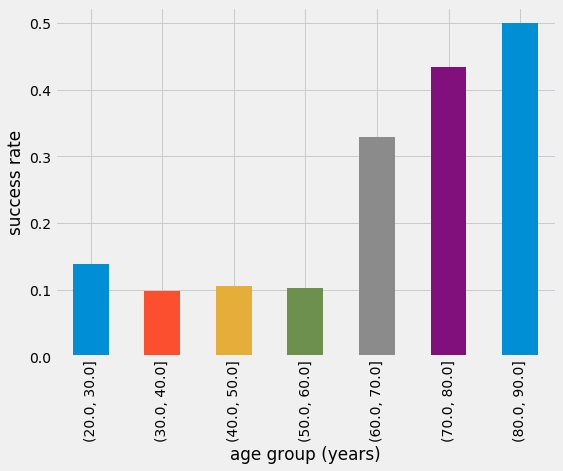

In [36]:
age_groups.y.plot.bar(figsize=(8,6))
plt.xlabel('age group (years)')
plt.ylabel('success rate')

## Removing irrelevent variable

In [37]:
to_keep = fi[fi.imp>0.005].cols
X_keep = X[to_keep].copy()
len(to_keep)

15

In [38]:
X.shape

(4521, 16)

In [39]:
X_train,X_valid,y_train,y_valid=train_test_split(X_keep,y,test_size=.3)

In [43]:
# Fitting the model
m = RandomForestClassifier(n_jobs=-1,n_estimators=500,oob_score=True,random_state=42,max_features=.9)
m.fit(X_train,y_train)
m.score(X_train,y_train)
y_pred = m.predict(X_valid)
print(roc_auc_score(y_valid,y_pred))

0.6682759916268585


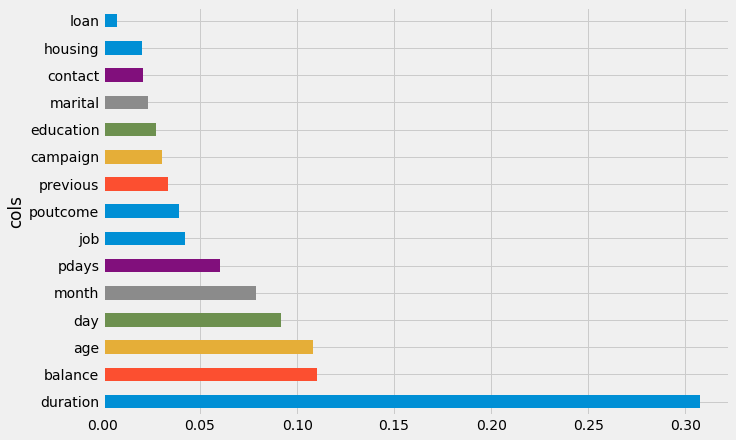

In [44]:
fi = rf_feat_importance(m, X_train)
plot_fi(fi)

# Clustering Analysis

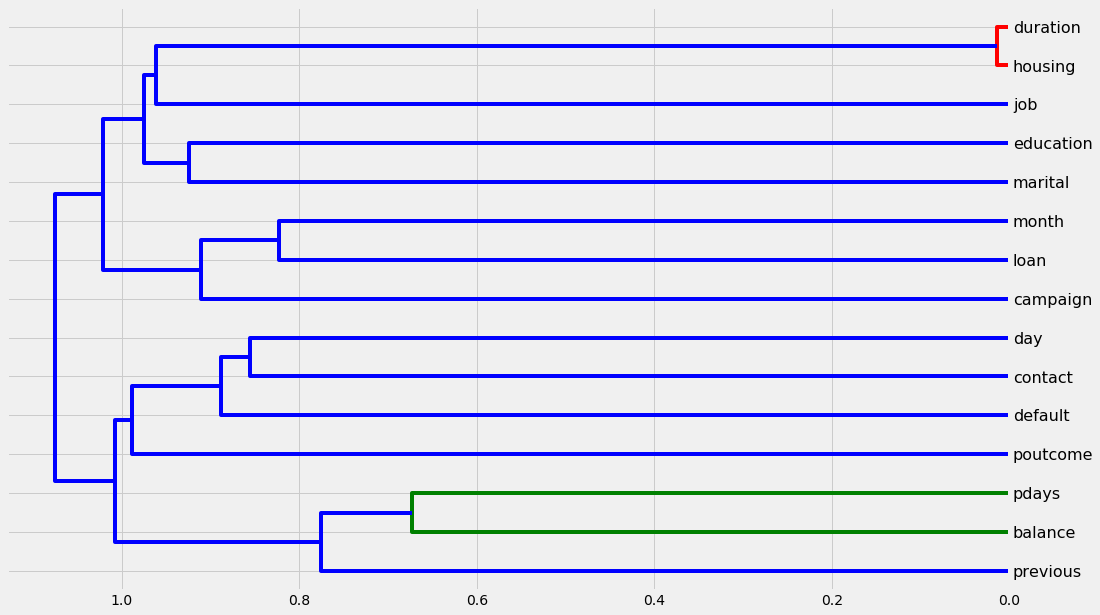

In [45]:
from scipy.cluster import hierarchy as hc
import scipy
corr = np.round(scipy.stats.spearmanr(X_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X.columns, 
      orientation='left', leaf_font_size=16)
plt.show()